# CNN training for pattern recognition on Range-Doppler Heatmap crossed with Static Range-Azimuth Heatmap

In [32]:
#import tensorflow.keras
import os
from os import listdir
from os.path import isdir, join
import numpy as np
from keras import layers, models, metrics
from subprocess import check_output
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Gathering the database

In [33]:
# CNN files paths
work_dir  = os.getcwd()
filename_dop = 'all_targets_cross_1080'
features_filename = filename_dop + '.npz'
model_filename = filename_dop + '.h5'

In [34]:
# Load feature set
features_set = np.load(join(work_dir, features_filename))
print('features for data set:',features_set.files)

features_set_dop = np.load(join(work_dir,features_filename))

features for data set: ['x_train_az', 'x_train_dop', 'y_train', 'x_val_az', 'x_val_dop', 'y_val', 'x_test_az', 'x_test_dop', 'y_test']


In [35]:
# Assign feature sets
x_train_az = features_set['x_train_az']
x_train_dop = features_set['x_train_dop']
y_train = features_set['y_train']
x_val_az = features_set['x_val_az']
x_val_dop = features_set['x_val_dop']
y_val = features_set['y_val']
x_test_az = features_set['x_test_az']
x_test_dop = features_set['x_test_dop']
y_test = features_set['y_test']

In [36]:
# Look at tensor dimensions
print('training input shape :',x_train_az.shape, x_train_dop.shape)
print('validation input shape :',x_val_az.shape, x_train_dop.shape)
print('test input shape :',x_test_az.shape, x_test_dop.shape)

training input shape : (756, 256, 31) (756, 31, 256)
validation input shape : (162, 256, 31) (756, 31, 256)
test input shape : (162, 256, 31) (162, 31, 256)


In [37]:
# Sample shape
ANGLE_BINS = x_train_dop.shape[1]
RANGE_BINS = x_train_dop.shape[2]

In [38]:
def transpose_dset(x):
    temp = np.zeros((x.shape[0],x.shape[2],x.shape[1]),dtype=np.float32)
    for i in range (len(x)):
        temp[i] = np.transpose(x[i])
    return(temp)

In [39]:
x_train_az = transpose_dset(x_train_az)
x_val_az = transpose_dset(x_val_az)
x_test_az = transpose_dset(x_test_az)

In [40]:
def concat_dset(x,y):
    temp = np.zeros((x.shape[0],x.shape[1]+y.shape[1],x.shape[2]),dtype=np.float32)
    for i in range (len(x)):
        temp[i]=np.concatenate((x[i],y[i]))
    return(temp)

In [41]:
x_train = concat_dset(x_train_az,x_train_dop)
x_val = concat_dset(x_val_az,x_val_dop)
x_test = concat_dset(x_test_az,x_test_dop)

In [42]:
# CNN for TF expects (batch (lote), height, width, channels)
# So we reshape the input tensors with a "color" channel of ''

x_train = x_train.reshape(int(x_train.shape[0]),
                          ANGLE_BINS*2,
                          RANGE_BINS,
                          1)
x_val = x_val.reshape(int(x_val.shape[0]),
                          ANGLE_BINS*2,
                          RANGE_BINS,
                          1)
x_test = x_test.reshape(int(x_test_az.shape[0]),
                        ANGLE_BINS*2,
                        RANGE_BINS,
                        1)

print('number of training samples :',x_train.shape[0])
print('number of validation samples :',x_val.shape[0])
print('number of test samples :',x_test.shape[0])

sample_shape = x_test.shape[1:]
print('Sample shape :',sample_shape)

number of training samples : 756
number of validation samples : 162
number of test samples : 162
Sample shape : (62, 256, 1)


## CNN Model construction and training

### Model Construction

In [43]:
# Read CSV Function
def readCSV(filename):
    data = np.loadtxt(filename, dtype = np.float32, delimiter = ' ')
    return data

y = readCSV(join(work_dir,"Dataset\\Azimuth\\idle\\2024_7_4_10_16_16_idle_0.csv"))
y = np.transpose(readCSV(join(work_dir,"Dataset\\Doppler\\idle\\2024_7_4_10_16_14_idle_0.csv")))

In [44]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()

# Convolution filters
model.add(layers.Conv2D(filters=4, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', input_shape=sample_shape, name = 'Conv2D_layer1'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer1'))

model.add(layers.Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv2D_layer2'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer2'))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv2D_layer3'))
model.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer3'))

# Classifier
model.add(Flatten())
model.add(Dense(128, kernel_initializer='random_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, kernel_initializer='random_normal', activation='relu'))
model.add(Dropout(0.5))

# Check Number of Classes Before Training
model.add(Dense(3, activation='sigmoid'))

# Display model
model.layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_layer1 (Conv2D)          │ (None, 62, 256, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer1 (MaxPooling2D)   │ (None, 31, 128, 4)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer2 (Conv2D)          │ (None, 31, 128, 16)    │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer2 (MaxPooling2D)   │ (None, 15, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer3 (Conv2D)          │ (None, 15, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_layer3 (MaxPooling2D)   │ (None, 7, 32, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       917,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 927,131 (3.54 MB)

 Trainable params: 927,131 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [45]:
# PatientEearly Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40, restore_best_weights=True)

# Add training parameters to model
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.001), #SGD, RMSProp, Adam, nadam
             loss_weights=0.01,
             metrics=['accuracy'])

# Train
history = model.fit(x_train,
                   y_train,
                   epochs=250,
                   batch_size=4,
                   validation_data=(x_val,y_val),
                   callbacks=[es])

Epoch 1/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.3640 - loss: 0.0110 - val_accuracy: 0.3086 - val_loss: 0.0110
Epoch 2/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4586 - loss: 0.0101 - val_accuracy: 0.6543 - val_loss: 0.0050
Epoch 3/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6650 - loss: 0.0053 - val_accuracy: 0.6790 - val_loss: 0.0064
Epoch 4/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7282 - loss: 0.0055 - val_accuracy: 0.6605 - val_loss: 0.0042
Epoch 5/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7770 - loss: 0.0042 - val_accuracy: 0.9568 - val_loss: 0.0033
Epoch 6/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8565 - loss: 0.0030 - val_accuracy: 0.9691 - val_loss: 0.0028
Epoch 7/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8946 - loss: 0.0025 - val_accuracy: 0.9444 - val_loss: 0.0034
Epoch 8/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9312 - loss: 0.0020 - 

### Plotting results

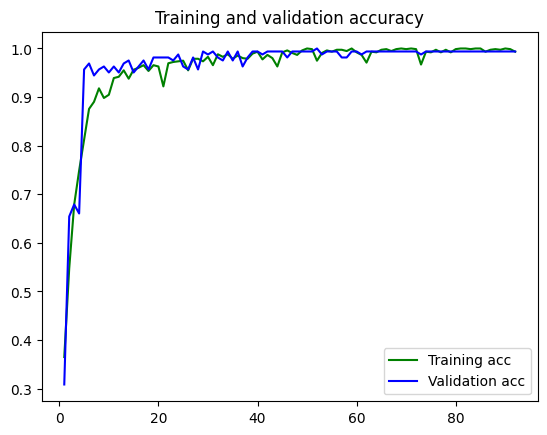

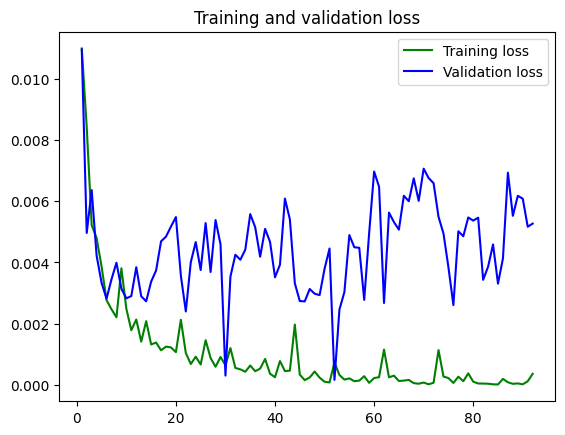

In [46]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#recall = history.history['recall_1']
#val_recall = history.history['val_recall_1']
#precision = history.history['precision']
#val_precision = history.history['val_precision']


epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
# Model evaluation on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

6/6 - 0s - 39ms/step - accuracy: 0.9938 - loss: 2.5440e-04


In [48]:
# Save the model as a file
models.save_model(model, work_dir + '\\' + model_filename)

print('saved model path :',work_dir + '/' + model_filename)

saved model path : c:\Users\Iman\Desktop\Stage\code\cross_feature/all_targets_cross_1080.h5


In [49]:
print(model.predict(x_test))
print(y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
[[6.04653749e-08 4.75127512e-14 1.00000000e+00]
 [8.18497268e-04 3.66960165e-07 9.99595940e-01]
 [9.03227031e-01 2.76975743e-02 2.37169608e-01]
 [9.11749601e-01 2.53001191e-02 2.24017575e-01]
 [8.54954004e-01 2.37297583e-02 3.10846925e-01]
 [1.54415165e-08 5.87488881e-15 1.00000000e+00]
 [8.89847577e-01 2.71208510e-02 2.59365469e-01]
 [3.07526477e-10 1.00000000e+00 5.34893125e-08]
 [9.28069949e-01 2.03925464e-02 1.96099430e-01]
 [8.27929676e-01 1.93357915e-02 3.54970574e-01]
 [8.98585200e-01 2.89920773e-02 2.44328961e-01]
 [8.98036599e-01 2.89884135e-02 2.45223463e-01]
 [1.45135156e-04 2.58182755e-08 9.99926329e-01]
 [5.07484600e-02 2.88418843e-04 9.72857594e-01]
 [6.37221954e-15 1.00000000e+00 3.68713532e-11]
 [2.11013464e-19 1.00000000e+00 1.11450088e-14]
 [5.56926365e-14 1.00000000e+00 8.64061184e-11]
 [9.22681153e-01 2.20164787e-02 2.05881804e-01]
 [8.98574114e-01 2.90010348e-02 2.44268209e-01]
 [1.67253495e-06 7.43110087e-12 9.99999344e-01]
 

## Confusion matrix

In [50]:
import seaborn as sns
import tensorflow as tf


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


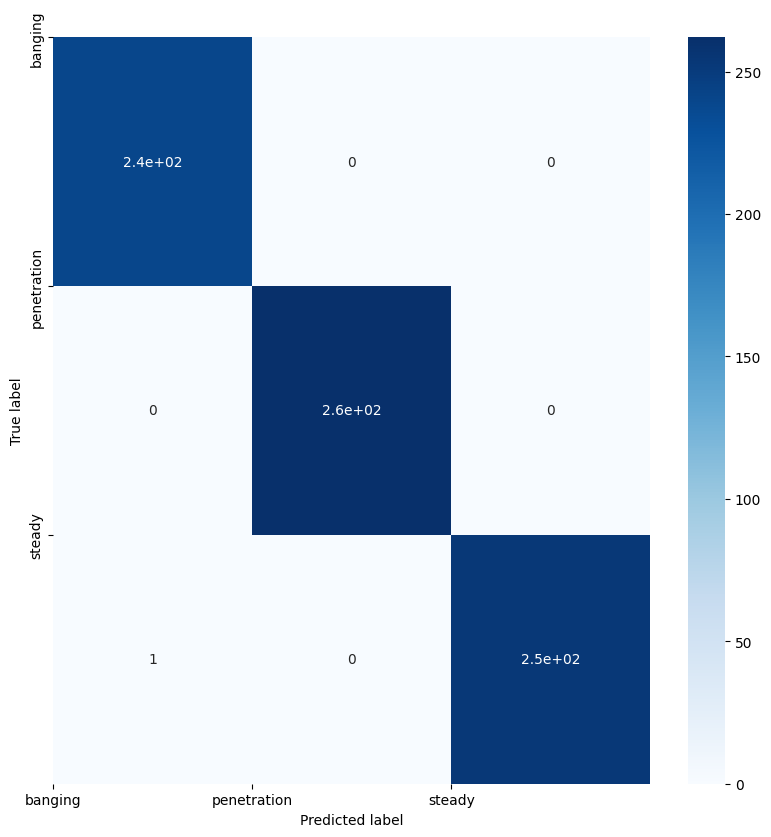

In [51]:
y_true=y_train
predict_y=model.predict(x_train)
y_pred=np.argmax(predict_y,axis=1)

classes = [0,1,2]
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')) #/ con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([0,1,2],['banging', 'penetration','steady'])
plt.yticks([0,1,2],['banging', 'penetration','steady'])
plt.show()

In [ ]:
# Prediction test with unclassified parameters
import scipy.interpolate as spi

# Load archive with the data to be predicted, put in shape with preparing_dataset_1folder
test_npz = np.load(os.getcwd()+'\\all_targets_0_13017_test_classes_55.npz')
test_in = test_npz['x_test']                                  

print(test_in.shape)
test_in_reshape = test_in.reshape(int(test_in.shape[0]/(NUMBER_ROWS_AZ)),                  # Resize with sample shape
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ,
                          1)

print('number of samples :',test_in_reshape.shape[0])
print('test samples shape :',test_in_reshape.shape[1:])

# Prediction on test sample pack
label = model_az.predict(test_in_reshape)
num_samples = test_in_reshape.shape[0]

# Loop throught the sample pack to display some of the predictions
for i in range (0,num_samples,10):
    print("Predicted Class for sample",i,"(0-idle, 1-presence) \n0 : ",label[i][0],"\n1 : ",label[i][1])    # Print predicted class
    sample = test_in[128*i:128*(i+1),:].reshape(
                          NUMBER_ROWS_AZ,
                          NUMBER_COlUMNS_AZ)
    range_res = 0.0436
    range_bins = sample.shape[0]
    angle_bins = sample.shape[1]
    theta = np.arcsin(np.linspace(-angle_bins / 2 + 1, angle_bins / 2 - 1, angle_bins) * (2 / angle_bins))  # Angular linear space for plotting
    range = np.linspace(0, range_bins - 1, range_bins) * range_res                                          # Range linear space for plotting
    range = np.maximum(range,0)                                                                                 # Keep only positive range value (later add range bias correction)
    range_depth = range_bins * range_res                                                         
    range_width, grid_res = range_depth/2, 64

    # Grid construction
    posX = np.outer(range, np.sin(theta))
    posY = np.outer(range, np.cos(theta))
    xlin = np.linspace(-np.floor(range_width), np.ceil(range_width), angle_bins)
    ylin = np.linspace(0, range_depth, range_bins)
    xgrid, ygrid = np.meshgrid(xlin, ylin)
    ra_grid = spi.griddata((posX.flatten(), posY.flatten()), sample.flatten(),(xgrid, ygrid), method='cubic')
    grid_init = 1
        
    hmplot = plt.contourf(xlin,ylin,sample,cmap='Spectral_r')
    plt.title(i)
    plt.show()
    #print("Expected prediction : ",expected[i],"\n")


"""     fig, subs = plt.subplots(2,2)
    for x in range(0,4,1): 
        f = sample[:,:,x]
        # read the csv file
        if (x < 2):
            subs[x][0].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto')
        else:
            subs[x-2][1].imshow(f, cmap='Spectral_r', interpolation='nearest', aspect='auto') """ #Doppler plotting

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Iman\\Desktop\\Stage\\code\\all_targets_0_13017_test_classes_55.npz'